# Comparison of analyses: f5c, Remora, basecalled modifications

In this notebook the predictions about modified positions are being visualised for the three method:
- Ionic current analysis following f5c's signal alignment (see: F5c_ionic_current_analysis_tRNAs.ipynb)
- Ionic current analysis following Remora's signal alignment (see: Remora_ionic_current_analysis_tRNAs)
- Modification basecalling analysis (Dorado modification basecalling + modkit pileup) (see: Basecalled_modifications_modkit_analysis_tRNAs.ipynb)
- Sequential mismatches (generated by IGV inspection)
Correspondence of these analyses are visualised in heatmaps per tRNA.

The content of this notebook:
1. Import of required python packages
2. Data loading
3. 

## 1. Import of required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

## 2. Data loading

### Define sequence of tRNA of interest

In [2]:
seq_Glu_CTC_1_1 = "TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA"
seq_Gly_GCC_2_1 = "GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA"
seq_Leu_CAA_1_1_WI = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_1 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTAAGCTTCCTCCGCGGTGGGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_2 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTTGGCTTCCTCGTGTTGAGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"

In [3]:
sequence = seq_Leu_CAA_1_1_WI

### Remora results

In [4]:
results_Remora = pd.read_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_Remora_MWU_subsampling_Leu_CAA_1_1_WI.csv")
list_positions_Remora = list(results_Remora['position'])
print(f"Number of predicted modified positions:\t{len(sorted(set(list_positions_Remora)))}")
print(f"The predicted modified positions:\t{sorted(set(list_positions_Remora))}")

Number of predicted modified positions:	13
The predicted modified positions:	[19, 20, 21, 22, 28, 29, 38, 44, 54, 56, 62, 63, 70]


### f5c results

In [5]:
results_f5c = pd.read_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_f5c_MWU_subsampling_Leu_CAA_1_1_WI.csv")
list_positions_f5c = list(results_f5c['position'])
print(f"Number of predicted modified positions:\t{len(sorted(set(list_positions_f5c)))}")
print(f"The predicted modified positions:\t{sorted(set(list_positions_f5c))}")

Number of predicted modified positions:	7
The predicted modified positions:	[28, 35, 41, 47, 51, 54, 79]


### Basecalled modification results

In [6]:
results_modkit = pd.read_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_modkit_filtered_Leu_CAA_1_1_WI.csv")
list_positions_modkit = list(results_modkit['start_position'])
print(f"Number of predicted modified positions:\t{len(sorted(set(list_positions_modkit)))}")
print(f"The predicted modified positions:\t{sorted(set(list_positions_modkit))}")

Number of predicted modified positions:	3
The predicted modified positions:	[29, 48, 63]


In [7]:
# Convert the results into a dictionary with position as key and the percentage of modified reads as value
modkit_dict = {}
# Make sure only one entry per position
subset_data = results_modkit[['start_position', 'percent_canonical']]
subset_data = subset_data.drop_duplicates()

# Calculate the percentage of non-canonical reads for predicted positions. This means that several predicted modifications
# at the same position are combined.
for pos in list_positions_modkit:
    percentage = subset_data[subset_data['start_position'] == pos]['percent_canonical'].item()
    modkit_dict[pos] = 100-percentage

### Sequential mismatches results

In [8]:
results_IGV = pd.read_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/IGV_mismatches_positions_Leu_CAA_1_1_WI.csv")
list_positions_IGV = list(results_IGV['Position'])
print(f"Number of predicted modified positions:\t{len(sorted(set(list_positions_IGV)))}")
print(f"The predicted modified positions:\t{sorted(set(list_positions_IGV))}")

Number of predicted modified positions:	14
The predicted modified positions:	[28, 36, 37, 40, 47, 48, 52, 53, 56, 60, 65, 67, 68, 69]


In [9]:
# Convert the results into a dictionary with position as key and the percentage of reads with mismatches as value
IGV_dict = {}
for pos in list_positions_IGV:
    percentage = results_IGV[results_IGV['Position'] == pos]['Percentage mismatch'].item()
    IGV_dict[pos] = percentage

## 3. Removing positions due to IGV results and/or modkit of IVT
Fill in the positions which are regarded as unreliable due to either sequential mismatches or predicted modifications within the IVT sample.

In [10]:
positions_to_remove = [33, 51, 57]

In [11]:
for position in positions_to_remove:
    # By enlarging the p-value, they will be filtered out before plotting
    results_f5c.loc[results_f5c['position'] == position, 'adjusted_pval_mean'] = 100
    results_Remora.loc[results_Remora['position'] == position, 'adjusted_pval_mean'] = 100
    # For the modkti and IGV dictionaries: remove if key exists, ignore if not
    modkit_dict.pop(position, None) 
    IGV_dict.pop(position, None)  # safely remove if exists, ignore if not

## 4. Heatmap

Remora: 13 positions with adjusted p-value < 0.01
f5c: 6 positions with adjusted p-value < 0.01


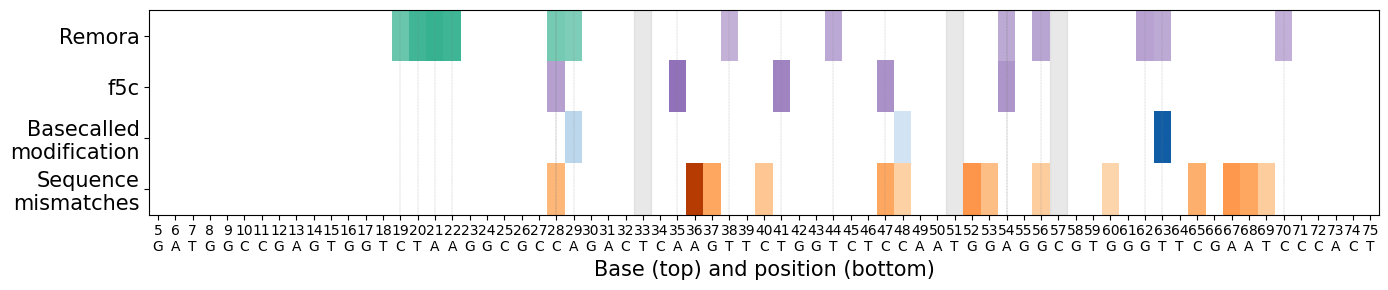

In [12]:
# 1. Extract and prepare RBC & p-value data
# --- Extract values from results tables ---
positions1        = results_Remora['position'].values
RBC_means_1       = results_Remora['RBC_mean'].values
adjusted_pvals1   = results_Remora['adjusted_pval_mean'].values

positions2        = results_f5c['position'].values
RBC_means_2       = results_f5c['RBC_mean'].values
adjusted_pvals2   = results_f5c['adjusted_pval_mean'].values

# --- Set significance threshold ---
pval_threshold = 0.01

# --- Mask RBC values by significance ---
RBC_masked1 = np.where(adjusted_pvals1 < pval_threshold, RBC_means_1, np.nan)
RBC_masked2 = np.where(adjusted_pvals2 < pval_threshold, RBC_means_2, np.nan)

# --- Count significant positions ---
num_significant1 = np.count_nonzero(~np.isnan(RBC_masked1))
num_significant2 = np.count_nonzero(~np.isnan(RBC_masked2))

print(f"Remora: {num_significant1} positions with adjusted p-value < {pval_threshold}")
print(f"f5c: {num_significant2} positions with adjusted p-value < {pval_threshold}")

# --- Define full base position range ---
all_positions = np.arange(0, 81)  # inclusive positions 0–80

# --- Map RBC data onto full position range ---
s1 = pd.Series(RBC_masked1, index=positions1).reindex(all_positions)
s2 = pd.Series(RBC_masked2, index=positions2).reindex(all_positions)

# Convert to 2D arrays (rows=methods, cols=positions)
remora_data = s1.values[np.newaxis, :]
f5c_data    = s2.values[np.newaxis, :]


# 2. Prepare additional annotation tracks
# --- Zoom range for plotting ---
x_start = 5
x_end   = 75
zoomed_positions = np.arange(x_start, x_end + 1)
n_cols = len(zoomed_positions)

# --- Row heights ---
highlight_row_height = 0.1
main_row_height      = 0.1

# --- External annotation data (modkit & IGV) ---
modkit_row = np.array([modkit_dict.get(int(pos), np.nan) for pos in all_positions])[np.newaxis, :]
IGV_row    = np.array([IGV_dict.get(int(pos), np.nan)    for pos in all_positions])[np.newaxis, :]

# --- Custom diverging colormap for RBC data ---
color_control = "#009E73"  # green
color_IVT     = "#7851A9"  # purple
custom_cmap   = LinearSegmentedColormap.from_list(
    "custom_bi_color", [color_IVT, "white", color_control], N=256
)

# --- Compute vertical extents for each track (bottom to top) ---
igv_ymin,    igv_ymax    = 0, highlight_row_height
modkit_ymin, modkit_ymax = igv_ymax, igv_ymax + highlight_row_height
f5c_ymin,    f5c_ymax    = modkit_ymax, modkit_ymax + main_row_height
remora_ymin, remora_ymax = f5c_ymax, f5c_ymax + main_row_height

# --- Slice data arrays to zoomed range ---
IGV_zoom    = IGV_row[:,     x_start:x_end + 1]
modkit_zoom = modkit_row[:,  x_start:x_end + 1]
f5c_zoom    = f5c_data[:,    x_start:x_end + 1]
remora_zoom = remora_data[:, x_start:x_end + 1]


# 3. Plotting the stacked tracks
fig, ax = plt.subplots(figsize=(14, 3))

# --- Track 1 (bottom): IGV mismatches ---
ax.imshow(
    IGV_zoom, aspect='auto', cmap=plt.cm.Oranges,
    norm=colors.Normalize(vmin=0, vmax=100), interpolation='none',
    extent=[x_start, x_end + 1, igv_ymin, igv_ymax]
)

# --- Track 2: Modkit basecalls ---
ax.imshow(
    modkit_zoom, aspect='auto', cmap=plt.cm.Blues,
    norm=colors.Normalize(vmin=0, vmax=100), interpolation='none',
    extent=[x_start, x_end + 1, modkit_ymin, modkit_ymax]
)

# --- Track 3: f5c RBC ---
ax.imshow(
    f5c_zoom, aspect='auto', cmap=custom_cmap,
    vmin=-1, vmax=1, extent=[x_start, x_end + 1, f5c_ymin, f5c_ymax]
)

# --- Track 4 (top): Remora RBC ---
ax.imshow(
    remora_zoom, aspect='auto', cmap=custom_cmap,
    vmin=-1, vmax=1, extent=[x_start, x_end + 1, remora_ymin, remora_ymax]
)


# 4. Axis labels & annotations
# --- Y-tick labels (track names) ---
yticks = [
    (remora_ymin + remora_ymax) / 2,
    (f5c_ymin + f5c_ymax) / 2,
    (modkit_ymin + modkit_ymax) / 2,
    (igv_ymin + igv_ymax) / 2,
]
ax.set_yticks(yticks)
ax.set_yticklabels(
    ['Remora', 'f5c', 'Basecalled\nmodification', 'Sequence\nmismatches'],
    fontsize=15
)

# --- X-axis: base + position labels ---
sequence_whole   = sequence
zoomed_sequence  = sequence_whole[x_start:x_end + 1]
combined_labels  = [f"{pos}\n{base}" for pos, base in zip(zoomed_positions, zoomed_sequence)]
ax.set_xticks(zoomed_positions + 0.5)
ax.set_xticklabels(combined_labels, fontsize=10)
ax.set_xlabel("Base (top) and position (bottom)", fontsize=15)


# 5. Highlight significant & excluded positions
# --- Vertical lines for significant positions ---
for pos in all_positions[~np.isnan(s1.values)]:
    if x_start <= pos <= x_end:
        ax.axvline(pos + 0.5, color='grey', linestyle='--', linewidth=0.2, alpha=0.9)

for pos in all_positions[~np.isnan(s2.values)]:
    if x_start <= pos <= x_end:
        ax.axvline(pos + 0.5, color='grey', linestyle='--', linewidth=0.2, alpha=0.9)

# --- Grey shading for excluded positions ---
for pos in positions_to_remove:
    if x_start <= pos <= x_end:
        ax.axvspan(pos, pos + 1, color='lightgrey', alpha=0.5, zorder=-1)


# 6. Final plot adjustments
ax.set_xlim(x_start, x_end + 1)
ax.set_ylim(0, remora_ymax)
plt.title("", fontsize=15)
plt.tight_layout()
plt.show()


### Only plotting the legend bars

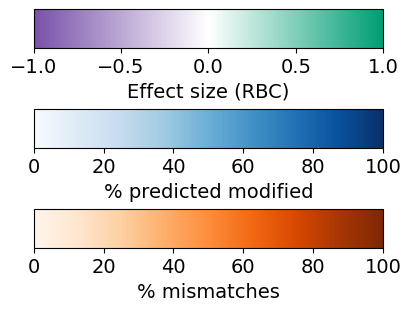

In [13]:
# --- Dummy data for each colorbar ---
dummy_data_100 = np.array([[0, 50, 100]])  # For IGV, Modkit, Known
dummy_data_rbc = np.array([[-1, 0, 1]])    # For Remora/f5c

# --- Colormaps and normalization ---
igv_cmap = plt.cm.Oranges
modkit_cmap = plt.cm.Blues
known_cmap = plt.cm.Blues

igv_norm = colors.Normalize(vmin=0, vmax=100)
modkit_norm = colors.Normalize(vmin=0, vmax=100)
known_norm = colors.Normalize(vmin=0, vmax=100)

# Custom diverging colormap for RBC
color_control = "#009E73"  # Green
color_IVT = "#7851A9"      # Purple
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_bi_color", [color_IVT, "white", color_control], N=256
)
rbc_norm = colors.Normalize(vmin=-1, vmax=1)

# --- Create figure for colorbars only ---
fig, axs = plt.subplots(nrows=3, figsize=(4, 3), layout="constrained")

# RBC colorbar (Remora/f5c)
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=rbc_norm, cmap=custom_cmap),
    cax=axs[0], orientation='horizontal'
)
cbar1.set_label('Effect size (RBC)', fontsize=14)
cbar1.ax.tick_params(labelsize=14)

# Modkit colorbar
cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=modkit_norm, cmap=modkit_cmap),
    cax=axs[1], orientation='horizontal'
)
cbar2.set_label('% predicted modified', fontsize=14)
cbar2.ax.tick_params(labelsize=14)

# IGV colorbar
cbar3 = fig.colorbar(
    plt.cm.ScalarMappable(norm=igv_norm, cmap=igv_cmap),
    cax=axs[2], orientation='horizontal'
)
cbar3.set_label('% mismatches', fontsize=14)
cbar3.ax.tick_params(labelsize=14)

plt.show()
